# ***with rescaled minst***

#### This submission is for... (*put up to three people*)
- Huxin Pan (2329057)


# Exercise 2B - Generative Adversarial Networks

In this exercise, you need to build a simple generative adversarial network to perform image generation.

**Important Notice**: Throughout the notebook, basic structures are provided such as functions and classes without bodies or partial bodies, and variables that you need to assign to. **Don't change the names of functions, variables, and classes - and make sure that you are using them!** You're allowed to introduce helper variables and functions. Occasionally, we use **type annotations** that you should follow. They are not enforced by Python. Whenenver you see an ellipsis `...` or TODO comment, you're supposed to insert code.

## Task: Image generation

In this assignment, you will be asked to implement Generative Adversarial Network (GAN) and train it in order to perform image generation. The idea is to learn the training data distribution by your model and use this model to synthesize new images from the corresponding distribution.

In GAN, we basically have two different models; generator and discriminator. While the Generator is responsible for synthesizing images and try to fool the Discriminator, Discriminator tries to distinguish real and fake samples. Our Discriminator network is a traditional classification network that performs binary classification; real and fake. Therefore, we will train our Discriminator with real and fake samples to learn to distinguish them. On the other hand, our the Generator is a generative model that takes a random noise, that is sampled from a known distribution (e.g., Uniform distribution), and tries to synthesize an image by performing upsampling. The goal of the Generator is to get "real" output from the Discriminator for the output that it synthesized. Meanwhile, the Discriminator goal is to recognize that the synthesized image by the Generator is fake.

We need to train both network simultaneously, therefore, we follow minimax game strategy and use the following formula:

$$\underset{G}{min}\; \underset{D}{max}\; E_{x\sim p_{data}} [logD(x)] + E_{z\sim p(z)}[log(1-D(G(z)))]$$

where $z \sim p(z)$ are the random noise that we sample, D represents the Discriminator network, $ x \sim p(data) $ indicates the real/training data distribution, and G states the Generator network. 

### Rules
In the assignment, we provide some basic codes or function names. You should follow the provided structure and only fill the blocks start with TODO keyword and end with END keyword. If you think that the provided code blocks and functions are not enough to do some steps / process or if you think that there are missing details, then you are allowed to add further codes / blocks / functions. However, please explain why you need it / them.

Besides, please do not forget to include your comments to the codes that you will write.

It is forbidden to get codes from the internet. Please implement yourself.

You are allowed to do the assignment as a group (maximum of 3 people). You can also do it alone.

If you implement the requested functions for the other exercise(s) (e.g., exercise 1 or exercise 2a), you can use the same code by just copy-paste from there and put a comment about it.

Please submit your file / files as a .zip and the name should be NN2022_assignment2_studentsID.zip. Inside the .zip, there should be a README file that should contain student ID, first name and last name. If you do it as a group, it is enough to do the submission one time but do not forget to write student ID, first name and last name of all members of your group. You can directly submit your file to dogucan.yaman@kit.edu

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch.nn as nn
from torch.autograd import Variable
from torch import Tensor


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Utility functions

In [ ]:
def show_images(images):
    # visualize an image
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    # Normalize the image to be between [-1, 1]
    return ((x / 255.0) * 2) - 1

def deprocess_img(x):
    # Denormalize the image to be between [0, 255]
    return ((x + 1) / 2) * 255.0

### Read dataset

##### MNIST dataset 

- Hand written digit dataset
- 10 classes in total [0, 9]
- 60000 training images
- 10000 test images
- Grayscale images
- 28 $ \times $ 28 $ \times $ 1

In [ ]:
# You can change batch size according to your hardware
batch_size = 128  #4

shuffle = True

transform_mnist = transforms.Compose( [
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5), std=(0.5))
                
                
])

# transform_mnist = transforms.Compose([transforms.ToTensor()]
                
#                 ) 


mnist_dataset_train = torchvision.datasets.MNIST('/tmp/mnist/data', 
                                            train=True, 
                                            download=True, 
                                            transform=transform_mnist)

mnist_dataset_test = torchvision.datasets.MNIST('/tmp/mnist/data', 
                                            train=False, 
                                            download=True, 
                                            transform=transform_mnist)

data_loader_train = torch.utils.data.DataLoader(mnist_dataset_train,
                                        batch_size=batch_size,
                                        shuffle=shuffle,
                                        num_workers=1)

data_loader_test = torch.utils.data.DataLoader(mnist_dataset_test,
                                        batch_size=1,
                                        shuffle=False,
                                        num_workers=1)

100%|██████████| 9912422/9912422 [00:00<00:00, 85005216.24it/s]


Extracting /tmp/mnist/data/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 33435190.13it/s]


Extracting /tmp/mnist/data/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25686620.52it/s]


Extracting /tmp/mnist/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18993548.12it/s]


Extracting /tmp/mnist/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/data/MNIST/raw



torch.Size([128, 1, 28, 28])
torch.Size([128])
tensor(-1.)
tensor(1.)


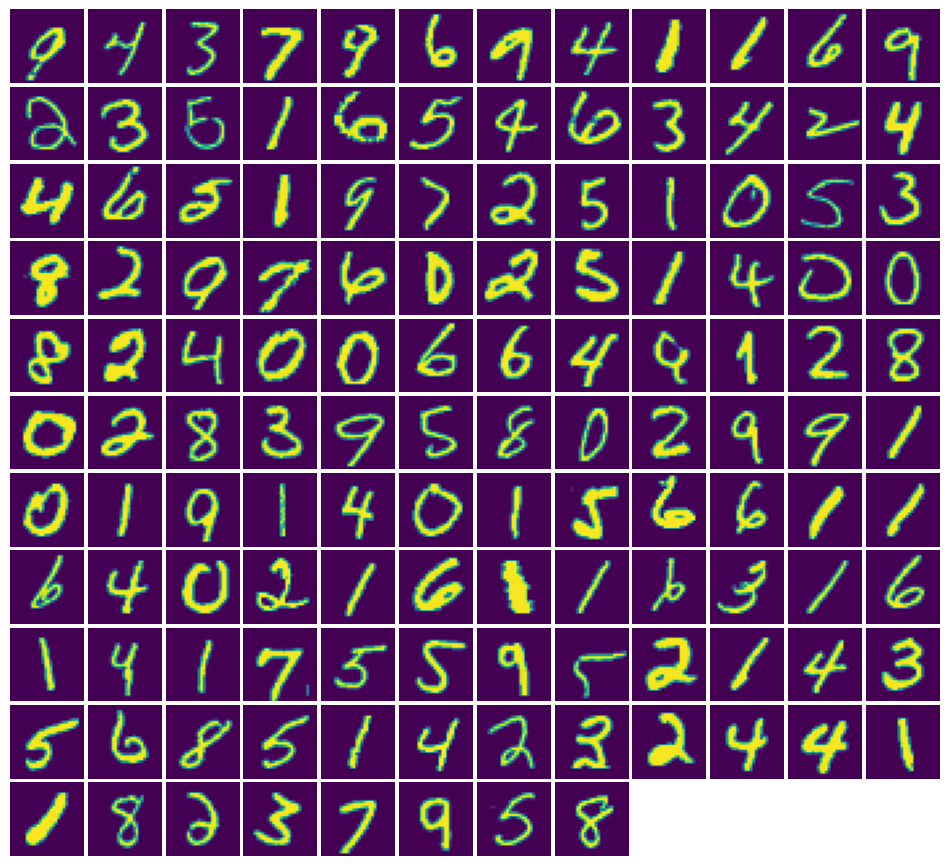

In [ ]:
sample = next(iter(data_loader_train))
print(sample[0].shape) # images
print(sample[1].shape) # labels

# Visualize a batch of images from the training set
show_images(deprocess_img (sample[0]))

print(sample[0].min())
print(sample[0].max())

### Implementation of basic components

In this block, you need to implement some operations and activation functions that you will be using when you design your generator and discriminator. You are not allowed to use off-the-shelf PyTorch functions for these operations such torch.nn.Conv2d

In [ ]:
np.random.seed(12345)
feature_map = np.random.randn(9, 10).astype(np.float32)
# output = Upsampling_layer(feature_map,(9,10), 2)



In [ ]:
import math
dtype = torch.float32
"""Added helpler Function random_weight and zero_weight"""
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True menas that we want to compute gradients for these Tensors during the baackward pass.
    Usage:
    to create FC Weight : random_weight(( in_features,num_neurons))
    to create ConvLayer Weight : random_weight((out_channel, in_channel, kH, kW))
    """
    if len(shape) ==2: # FC weight
      fan_in = shape[0]
    else:
      fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # generate weights at random bt standard normal disribution
    w = torch.empty(shape,device=device,dtype=dtype) # * np.sqrt(2. / fan_in)
    nn.init.xavier_uniform_(w, gain=nn.init.calculate_gain('relu'))
    w.requires_grad = True
    return w 

def zero_weight(shape):
    b = torch.randn(shape,device=device,dtype=dtype)
    b.requires_grad = True
    return b

class Linear_layer(nn.Module):
    # Implement a linear layer with a forward pass that you will be able to use during the architecture design
    def __init__(self, dim_features_in, number_of_neuron): #  Added extra para dim_features_in to eliminate ambiguity...
        """
        dim_features_in: input feature size
        number_of_neuron: hidden layer size
        
        """
        super().__init__()
        self.w = torch.nn.Parameter(torch.empty(dim_features_in,number_of_neuron))
        stdv = 1. / math.sqrt(self.w.size(1))
        self.w.data.uniform_(-stdv, stdv)
        self.b = torch.nn.Parameter(torch.empty(number_of_neuron))
        self.b.data.uniform_(-stdv, stdv)


    def forward(self,x:Tensor) -> Tensor:
        """
        x: data
        Implement forward pass
        """
        w = self.w.to(device)
        b = self.b.to(device)
        output = None
        output = x.mm(w) + b
        return output


"""  Test  """
te = Linear_layer(3,5)
x = torch.randn(10,3).to(device)
out = te(x)
out

for name, param in te.named_parameters():
    if param.requires_grad:
        print(name,param.data)
# print(out.shape)

"""End of Test"""


def Upsampling_layer(x, size=None, scale_factor=None):
      """
      Implement upsamling layer by using bilinear approach
      Input:
          x: input data
          size: output spatial size. It can be a scalar or a tuple   N,int ; N (..,tuple)
          scale_factor: scale factor to perform upsampling
      Output:
          output_map: Upsampled version of the input data x
          
      """
      x_H = size[0]
      x_W = size[1]
      resized_H = int(x_H * scale_factor)
      resized_W = int(x_W * scale_factor)
      output = np.zeros((resized_H, resized_W), dtype=x.dtype)

      def read_pixel(x, y):
        x = np.clip(x, 0, x_W - 1)
        y = np.clip(y, 0, x_H - 1)
        return input[y, x]

      def bilinear_interpolate(x, y):
          x1 = int(np.floor(x))
          x2 = x1 + 1

          y1 = int(np.floor(y))
          y2 = y1 + 1

          P11 = read_pixel(x1, y1)
          P12 = read_pixel(x1, y2)
          P21 = read_pixel(x2, y1)
          P22 = read_pixel(x2, y2)
          
          return (P11 * (x2 - x) * (y2 - y) + 
                  P12 * (x2 - x) * (y - y1) + 
                  P21 * (x - x1) * (y2 - y) + 
                  P22 * (x - x1) * (y - y1)) / ((x2 - x1) * (y2 - y1))

      for dst_y in range(resized_H):
          for dst_x in range(resized_W):
              src_x = (dst_x + 0.5) / scale_factor - 0.5
              src_y = (dst_y + 0.5) / scale_factor - 0.5
              output[dst_y, dst_x] = bilinear_interpolate(src_x, src_y)

      return output

"""Test"""

np.random.seed(12345)
feature_map = np.random.randn(9,3,24,10).astype(np.float32)
"""End """




def max_pooling(x, filter_size=2, stride=2):
    """
    Implement max pooling operation for an arbitrary input
    Input:
        x: input
        filter_size: abstract filter size to define the region size to perform pooling operation
        stride: step size for each movement between regions
    Output:
        output_map: output of max pooling operation
    """
    out = None

    # TODO: Implement the max-pooling forward pass                            #

    S1 = S2 = stride
    HP = filter_size
    WP = filter_size
    N, C, HI, WI = x.shape         # input dims
    HO = 1 + (HI - HP) // S1       # output height
    WO = 1 + (WI - WP) // S2       # output width

    # Helper function (warning: numpy version 1.20 or above is required for usage)
    to_fields = lambda x: np.lib.stride_tricks.sliding_window_view(x, (WP,HP,C,N))

    x_fields = to_fields(x.T).T[...,::S1,::S2].reshape(N, C, HP*WP, -1) # input local regions
    output_map = x_fields.max(axis=2).reshape(N, C, HO, WO)                    # pooled output


    # END 
    return output_map

"""Test"""
np.random.seed(12345)
feature_map = np.random.randn(9,3,24,10).astype(np.float32)
print(max_pooling(feature_map).shape)
"""End """

def relu_function(x):
    """
    x: input data
    """

    # Implement relu activation function

    # TODO
    out = None
    out = torch.maximum(x,torch.tensor([0]).to(device))
    # END
    return out

class ReLu(nn.Module):
    def forward(self, x):
        return relu_function(x)

rel = ReLu()
rel(torch.tensor([[9,3,24,-10],[9,-3,-24,10]]).to(device))

"""Test"""
x = torch.tensor([[9,3,24,-10],[9,-3,-24,10]]).to(device)
print(relu_function(x))
"""End """

def sigmoid_function(x):
    """
    x: input data
    """

    # Implement sigmoid activation function
    # TODO
    out = None

    out = 1.0/(1.0 + torch.exp(-x))
    
    # END
    return out

class Sigmoid(nn.Module):
    def forward(self, x):
        return sigmoid_function(x)



def tanh_function(x):
    """
    x: input data
    """

    # Implement tanh activation function
    # TODO
    out = None
    out = 2*sigmoid_function(2*x) - 1
    # END
    
    return out


def tanh_function_v2(x):
    """
    x: input data
    """

    # Implement tanh activation function
    # TODO
    out = None
    out = (torch.exp(x) - torch.exp(-x) )/ (torch.exp(x) + torch.exp(-x))
    # END
    return out
    
class Tanh(nn.Module):
    def forward(self, x):
        return tanh_function(x)

"""Test"""
x = torch.tensor([[9,3,24,-10],[9,-3,-24,10]])
print(tanh_function(x) - tanh_function_v2(x))
"""End """




def leakyrelu_function(x, alpha=0.01):
    """
    Implement Leaky ReLU activation function
    Input:
        x: data
        alpha: coefficient to use on the negative side
    Output:
        output: output of the LReLU function
    """
    output = None
    output = torch.maximum(x, x * alpha)
    return output

class LeakyReLu(nn.Module):

    def __init__(self, alpha=0.01):
        super().__init__()
        self.alpha = alpha

    def forward(self, x):
        return leakyrelu_function(x,self.alpha)



"""Test"""
lrl = LeakyReLu(0.1)
lrl(torch.tensor([[9,3,24,-10],[9,-3,-24,10]]))

x = torch.tensor([[9,3,24,-10],[9,-3,-24,10]])
print(x)
print(leakyrelu_function(x))
"""End """   

w tensor([[-0.3065,  0.3729, -0.2479, -0.2416, -0.3485],
        [ 0.0480,  0.2964, -0.3381, -0.4439, -0.1077],
        [-0.0191, -0.3572,  0.0481,  0.3844,  0.3401]])
b tensor([-0.1946, -0.0129,  0.0917,  0.3477,  0.0678])
(9, 3, 12, 5)
tensor([[ 9,  3, 24,  0],
        [ 9,  0,  0, 10]], device='cuda:0')
tensor([[ 0.0000e+00,  1.1921e-07,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -5.9605e-08,  0.0000e+00,  0.0000e+00]])
tensor([[  9,   3,  24, -10],
        [  9,  -3, -24,  10]])
tensor([[ 9.0000,  3.0000, 24.0000, -0.1000],
        [ 9.0000, -0.0300, -0.2400, 10.0000]])


'End '

## Vanilla GAN

### Generator


- Fully-connected layer from latent_dim to 1024
- ReLU activation function
- Fully-connected layer from 1024 to 1024
- ReLU activation function
- Fully-connected layer from 1024 to 784 (Output image: $ 28 \times 28 \times 1 $)
- TanH activation function


In [ ]:
import math

class VanillaGenerator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.img_shape = img_shape
        self.gen = nn.Sequential(
            Linear_layer(latent_dim, 1024),
            ReLu(),
            Linear_layer(1024, 1024),
            ReLu(),
            Linear_layer(1024, math.prod(img_shape)),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x).reshape(-1,*self.img_shape)

# """test"""
# testq = VanillaGenerator(1024,(28,28,1))
# testx = torch.randn(3,1024)
# testq(testx).shape


torch.Size([3, 28, 28, 1])

### Discriminator

- Fully-connected layer from 784 ($ 28 \times 28 \times 1 $) to 256
- LeakyReLU activation function with $ \alpha = 0.01 $
- Fully-connected layer from 256 to 256
- LeakyReLU activation function with $ \alpha = 0.01 $
- Fully-connected layer from 256 to 1


In [ ]:

class VanillaDiscriminator(nn.Module):
    def __init__(self, img_shape):
        super().__init__()
        self.disc = nn.Sequential(
            Linear_layer(math.prod(img_shape), 256),
            LeakyReLu(0.01),
            Linear_layer(256, 256),
            LeakyReLu(0.01),
            Linear_layer(256, 1),
            nn.Sigmoid(),  # Sigmoid replaced by nnSigmoid because , first one is prone to underflow, I will try to fix it later 
        )

    def forward(self, x):
        x = x.reshape(x.shape[0],-1)
        return self.disc(x)

# testm = VanillaDiscriminator((28,28,1))
# testx = torch.randn(10,28,28,1)
# testm(testx)

hidden_1.w
hidden_1.b
hidden_2.w
hidden_2.b
hidden_3.w
hidden_3.b
hidden_1.w
hidden_1.b
hidden_2.w
hidden_2.b
hidden_3.w
hidden_3.b


### Define Optimizer

In [ ]:

def get_optimizer(model,lr=1e-3,betas=(0.5,0.999),weight_decay=0):
    """
    Define an Adam optimizer with 1e-3 learning rate, 0.5 beta1, and 0.999 beta2 parameters
    
    Input:
        model: Provided model
    
    Returns:
        optimizer: An Adam optimizer with provided parameters
    """
    optimizer = torch.optim.Adam(model.parameters(),lr,betas,weight_decay=weight_decay)
    #optimizer = torch.optim.SGD(model.parameters(),lr=1e-1)
    return optimizer


### Create model

In [ ]:
latent_dim = 100 # you can change this

# Define generator and discriminator
# TODO

generator_vanilla = VanillaGenerator(latent_dim,(28,28,1)).to(device)
discriminator_vanilla = VanillaDiscriminator((28,28,1)).to(device)
# print(next(generator_vanilla.parameters()).device)

# generator_vanilla = Generator(latent_dim,784)
# discriminator_vanilla = Discriminator(784)

# END

# Perform weight initialization
# TODO
""" This was already Done inside init() of class Linear"""
# END

print(generator_vanilla)
print(discriminator_vanilla)

for name, param in generator_vanilla.named_parameters():
    if param.requires_grad:
        print(name)

for name, param in discriminator_vanilla.named_parameters():
    if param.requires_grad:
        print(name)
# Get optimizer
# optimizer_vanilla_G = get_optimizer(generator_vanilla)
# optimizer_vanilla_D = get_optimizer(discriminator_vanilla)

VanillaGenerator(
  (gen): Sequential(
    (0): Linear_layer()
    (1): ReLu()
    (2): Linear_layer()
    (3): ReLu()
    (4): Linear_layer()
    (5): Tanh()
  )
)
VanillaDiscriminator(
  (disc): Sequential(
    (0): Linear_layer()
    (1): LeakyReLu()
    (2): Linear_layer()
    (3): LeakyReLu()
    (4): Linear_layer()
    (5): Sigmoid()
  )
)
gen.0.w
gen.0.b
gen.2.w
gen.2.b
gen.4.w
gen.4.b
disc.0.w
disc.0.b
disc.2.w
disc.2.b
disc.4.w
disc.4.b


### Generate random noise

In [ ]:
def generate_noise(batch_size, latent_dim,seed=None):
    """
    Sample random noise from uniform distribution in the range  [-1, 1]
    Input:
        batch_size: The batch size of the noise 
        latent_dim: Dimension of the noise
    Output:
        A noise of shape (batch_size, latent_dim) and between -1 and +1
    """

    # TODO
    if seed is not None:
        torch.manual_seed(seed)

    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    random_noise = -2 * torch.rand(batch_size, latent_dim) + 1
    # END
    return random_noise

"""test"""
# x1=generate_noise(3,1024)
# x1.shape
# testq(x1).shape

'test'

### GAN loss

In [ ]:
class binary_cross_entropy_loss(nn.Module):
    def __init__(self):
        super(binary_cross_entropy_loss, self).__init__()

    def forward(self, pred, target):
        loss = None
        """
        Implement binary cross entropy loss
        pred: predictions
        target: ground truth labels
        """
        # TODO
        neg_abs = - pred.abs()
        loss = pred.clamp(min=0) - pred * target + (1 + neg_abs.exp()).log()
        loss = loss.mean()

        # END
        return loss
"""test"""
x = torch.tensor([[0.4,0.1,0.5],[0.2,0.2,0.6]])
y = torch.tensor([[1,0,0],[0,1,0]]).type(x.dtype)
x.type()
y.type()
bce = binary_cross_entropy_loss()
bceloss = bce(x,y)
print(bceloss)
criterion = nn.BCELoss()
s_loss = criterion(x,y)
print(s_loss)
print(bceloss-s_loss)
"""End of Test"""

class generator_loss(nn.Module):
    def __init__(self):
        super(generator_loss, self).__init__()
        self.bce_loss = binary_cross_entropy_loss()

    def forward(self, scores):
        """
        Implement generator loss by using self.bce_loss
        Input:
            scores: Output scores for the generated data
        Output:
            loss: Calculated loss value for the generator. It must be a scalar.
        """
        loss = None
        # TODO
        loss = self.bce_loss(scores, torch.ones_like(scores))
        # END
        return loss

"""test"""
x = torch.tensor([[0.4,0.1,0.5],[0.2,0.2,0.6]])
y = torch.tensor([[1,0,0],[0,1,0]])
gloss = generator_loss()
g_loss = gloss(x)
print(g_loss)


"""End of Test"""

class discriminator_loss(nn.Module):
    def __init__(self):
        super(discriminator_loss, self).__init__()
        self.bce_loss = binary_cross_entropy_loss()

    def forward(self, scores_real, scores_fake):
        """
        Implement discriminator loss by using self.bce_loss
        Input:
            scores_real: Output scores for the real data
            scores_fake: Output scores for the generated data
        Output:
            loss: Calculated loss value for the discriminator. It must be a scalar.
        """
        loss = None
        # TODO
        loss_fake = self.bce_loss(scores_fake, torch.zeros_like(scores_fake))
        loss_real = self.bce_loss(scores_real, torch.ones_like(scores_real))
        loss = loss_fake + loss_real
        # END
        return loss
"""test"""
x = torch.tensor([[0.4,0.1,0.5],[0.2,0.2,0.6]])
y = torch.tensor([[1,0,0],[0,1,0]])
dloss = discriminator_loss()
d_loss = dloss(y,x)
print(d_loss)
"""End of Test"""


tensor(0.7775)
tensor(0.7439)
tensor(0.0336)
tensor(0.5442)
tensor(1.4441)


'End of Test'

### Training

In [ ]:

# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 100
image_dim = 28 * 28 * 1  # 784
batch_size = 32
num_epochs = 15 #10

# disc = Discriminator(image_dim).to(device)
# gen = Generator(z_dim, image_dim).to(device)

# disc = VanillaDiscriminator((28,28,1)).to(device)
# gen = VanillaGenerator(z_dim,(28,28,1)).to(device)
disc = discriminator_vanilla
gen = generator_vanilla

fixed_noise = torch.randn((batch_size, z_dim)).to(device)

# Get optimizer
optimizer_vanilla_G = get_optimizer(generator_vanilla,lr=lr)#,weight_decay=0.3
optimizer_vanilla_D = get_optimizer(discriminator_vanilla,lr=lr,weight_decay=0.3)

opt_disc = optimizer_vanilla_D
opt_gen = optimizer_vanilla_G
print(opt_disc)
print(opt_gen)

criterion = nn.BCELoss()

fake_imgs = []
loss_log = {'loss_log_d': [],
       'loss_log_g':[]}

for epoch in range(num_epochs):
    """
    - Train one step discriminator
    - Train one step generator
    - Calculate necessary loss functions and perform optimization / weight update
    - Perform generation in the end of each epoch, calculate loss, save a batch of generated image
    """
    for batch_idx, (real, _) in enumerate(data_loader_train):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        torch.autograd.set_detect_anomaly(True)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = torch.clamp(disc(real).view(-1), min=1e-7, max=1-1e-7)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = torch.clamp(disc(fake).view(-1), min=1e-7, max=1-1e-7)
        #print(disc_fake)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        loss_log['loss_log_d'].append(lossD.item())
        loss_log['loss_log_g'].append(lossG.item())

        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}] Batch {batch_idx}/{len(data_loader_train)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            
    gen.eval()
    with torch.no_grad():
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        fake_imgs.append(fake.cpu().detach())
    gen.train()


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0.3
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)
Epoch [1/15] Batch 0/469                       Loss D: 0.7591, loss G: 0.5319
Epoch [1/15] Batch 100/469                       Loss D: 0.1784, loss G: 1.2436
Epoch [1/15] Batch 200/469                       Loss D: 0.4091, loss G: 4.2656
Epoch [1/15] Batch 300/469                       Loss D: 0.5802, loss G: 0.8992
Epoch [1/15] Batch 400/469                       Loss D: 0.7599, loss G: 0.7484
Epoch [2/15] Batch 0/469                       Loss D: 0.4311, loss G: 1.1226
Epoch [2/15] Batch 100/469                       Loss D: 0.5338, loss G: 1.168

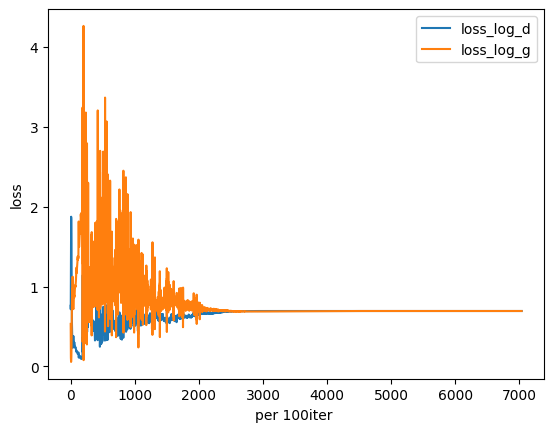

In [ ]:
plt.plot(loss_log['loss_log_d'])
plt.plot(loss_log['loss_log_g'])
plt.xlabel('per 100iter ')
plt.ylabel('loss')
plt.legend(['loss_log_d', 'loss_log_g'])

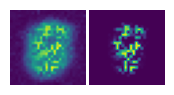

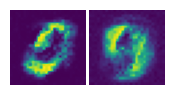

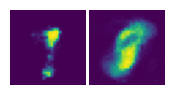

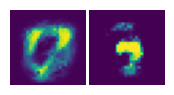

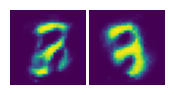

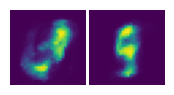

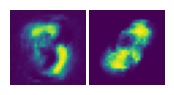

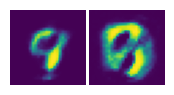

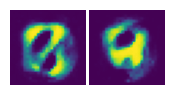

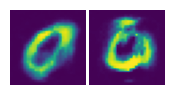

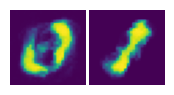

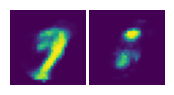

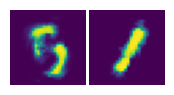

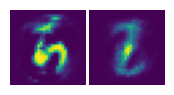

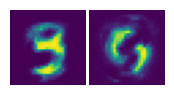

In [ ]:
len(fake_imgs)
type(fake_imgs[0])
for item in fake_imgs:
  show_images(deprocess_img (item [:2]))

### Visualization

torch.Size([96, 28, 28, 1])


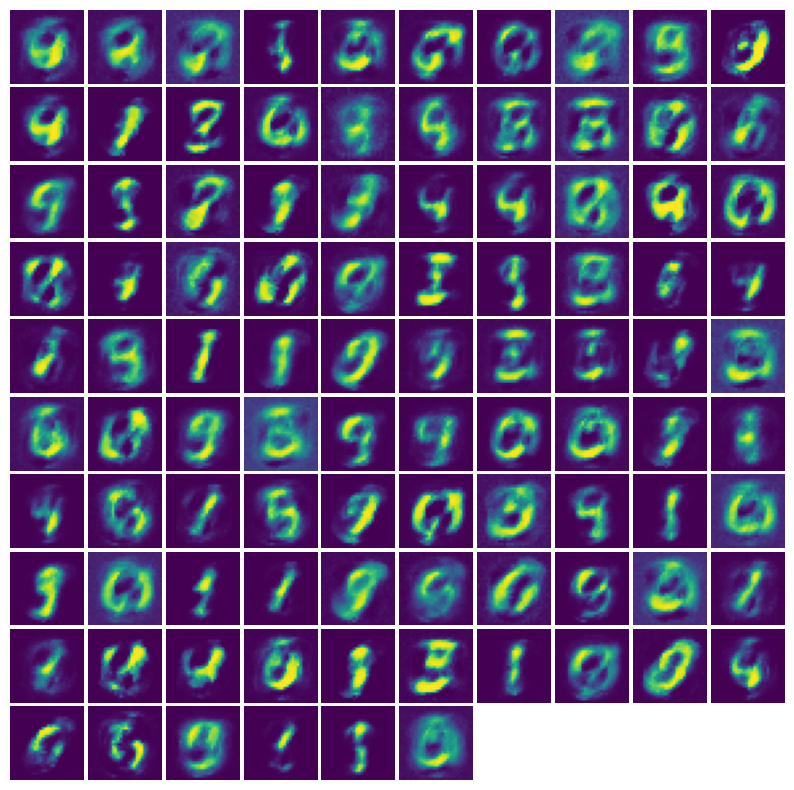

In [ ]:

input_noise = Tensor(generate_noise(batch_size, latent_dim)).to(device)
gen_imgs = generator_vanilla(input_noise)
print(gen_imgs.shape)
# Visualize generated image

show_images(deprocess_img (gen_imgs.cpu().detach()))

## Deep Convolutional GAN (DCGAN)

In the VanillaGAN, we only had fully-connected layers. However, in order to implement deep convolutional generative adversarial network (DCGAN), we need to have convolution layers. In the following code blocks, you first need to implement Conv layer and Transposed Conv layer. Afterwards, you will use them to design your Generator and Discriminator.

### Conv Layer

In [ ]:
# class ConvLayer(nn.Module):
#     def __init__(self,num_filter, kernel_size=3, stride=1, padding=0): 
#         """added argument num_filter"""
#         super(ConvLayer, self).__init__()        

#         # Define Convolution operation
        

#         self.w = torch.nn.Parameter(torch.empty(num_filter, 1, kernel_size, kernel_size))
#         stdv = 1. / math.sqrt( 3 * kernel_size**2 ) # 3 : # of in_channels by default
#         self.w.data.uniform_(-stdv, stdv)
#         self.b = torch.nn.Parameter(torch.empty(num_filter))
#         self.b.data.uniform_(-stdv, stdv)

#         self.conv_param = {'stride':stride,'pad':padding}

#         # END
        
#     def forward(self, x):
#         """
#         x: input data
#         output: output of the convolution layer
#         """
#         # TODO
#         output = None
#         ###########################################################################
#         # TODO: Implement the convolutional forward pass.                         #
#         # Hint: you can use the function np.pad for padding.                      #
#         ###########################################################################
#         # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#         P1 = P2 = P3 = P4 = self.conv_param['pad'] # padding: up = right = down = left
#         S1 = S2 = self.conv_param['stride']        # stride:  up = down
#         N, C, HI, WI = x.shape                # input dims  
#         F, _, HF, WF = self.w.shape                # filter dims
#         HO = 1 + (HI + P1 + P3 - HF) // S1    # output height      
#         WO = 1 + (WI + P2 + P4 - WF) // S2    # output width

#         # Helper function (warning: numpy version 1.20 or above is required for usage)
#         to_fields = lambda x: np.lib.stride_tricks.sliding_window_view(x, (WF,HF,C,N))

#         w_row = self.w.reshape(F, -1)                                            # weights as rows
#         x_pad = np.pad(x, ((0,0), (0,0), (P1, P3), (P2, P4)), 'constant')   # padded inputs
#         x_col = to_fields(x_pad.T).T[...,::S1,::S2].reshape(N, C*HF*WF, -1) # inputs as cols

#         output = (w_row @ x_col).reshape(N, F, HO, WO) + np.expand_dims(self.b, axis=(2,1))
#         #END
#         return output

# inpu = torch.randn(3,1,28,28)
# cl = ConvLayer(5)
# opu = cl(inpu)


# """
# """

class ConvLayer(nn.Module):
    def __init__(self, kernel_size=3, stride=1, padding=0):
        super(ConvLayer, self).__init__()        

        # Define Convolution operation
        # TODO

        # END
        
    def forward(self, x):
        """
        x: input data
        output: output of the convolution layer
        """
        # TODO

        # END
        return output

### Transposed Conv Layer

In [ ]:
class TransposedConvLayer(nn.Module):
    def __init__(self, kernel_size=3, stride=1, padding=1, output_padding=1):
        super(TransposedConvLayer, self).__init__()        

        # Define Transposed Convolution operation
        # TODO

        # END
        
    def forward(self, x):
        """
        x: input data
        output: output of the transposed convolution layer
        """
        # TODO

        # END
        return output

### Generator

In [ ]:
class Reshape(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(-1,64, 7,7)

class DCGenerator(nn.Module):
    def __init__(self, latent_dim, img_shape, features_g = 16):
        """
        latent_dim: len of noise feature = 100
        img_shape:  num of ouput image channels = 1
        features_g: hyperparameter of hidden_layer_feature_size

        Usage : 
        model = DCGenerator(latent_dim, img_shape ).to(device)
        result = gen3(torch.randn(N,latent_dim,1,1))

        """
        super(DCGenerator, self).__init__()        
        self.img_shape = img_shape

        # Define Generator's layers
        # TODO
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            #
            nn.Linear(latent_dim, 7 * 7 * features_g*4), #latent_dim -> 6272
            Reshape(),
            self._block(features_g*4 ,features_g*2, 4, 2, 0),  #  -> 3x3
            self._block(features_g * 2, features_g * 1, 4, 2, 0),  # -> 7x7
            # self._block(features_g * 16, features_g * 8, 4, 2, 1),  # -> 14x14
            # self._block(features_g * 8, features_g * 4, 3, 1, 1),  # -> 28X28
  
            nn.Conv2d(features_g, 1, kernel_size=7),
            #Output: N x channels_img x 64 x 64
            #nn.Tanh(),
        )
            # END
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding=0,
                bias=True,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(),)
        
    def forward(self, x):
        """
        x: input data
        output: output of the generator
        """
        # Implement forward step of the model
        # TODO
        output = self.net(x)
        # END
        return output

gen3 = DCGenerator(100, 1 ).to(device)
fixed_noise = generate_noise(4,100).to(device)
result = gen3(fixed_noise)
result.shape

torch.Size([4, 1, 28, 28])

### Discriminator

In [ ]:
class DCDiscriminator(nn.Module):
    def __init__(self, img_shape,features_d=64):
        super(DCDiscriminator, self).__init__()
        
        # Define Discriminator's layers
        self.disc = nn.Sequential(
            # input: N x channels_img x 28 x 28
            nn.Conv2d(img_shape, features_d, kernel_size=4, stride=2, padding=1),   #28 -> 14
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d*2, 4, 2, 1),  # 14 -> 7
            self._block(features_d * 2, features_d*4, 4, 2, 1), #7 -> 3
            self._block(features_d * 4, features_d*8, 4, 2, 1),# 3 -> 1
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=1, stride=1, padding=0),# 1 ->1
            nn.Sigmoid()
        )

    def _block( self,in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
 
    def forward(self, x):
        """
        x: input data
        output: output of the discriminator
        """

        # Implement forward step of the model
        # TODO
        return self.disc(x)
        # END



# result = torch.randn(16,1,28,28)    


de3 = DCDiscriminator(1,features_d=32).to(device)
result.shape
de3(result)


tensor([[[[0.5026]]],


        [[[0.5026]]],


        [[[0.5026]]],


        [[[0.5026]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)

### Create Model

In [ ]:
latent_dim = 100 # you can change this

# Define generator and discriminator
# TODO
dc_generator = None
dc_generator = DCGenerator(100, 1 ).to(device)
#dc_generator = DCGenerator(100 ).to(device)
# END

# Perform weight initialization
# TODO
dc_discriminator = None
dc_discriminator = DCDiscriminator(1).to(device)
# END

# Get optimizer
optimizer_dc_G = get_optimizer(dc_generator,lr=2e-4)#,weight_decay=0.3
print(optimizer_dc_G)
optimizer_dc_D = get_optimizer(dc_discriminator,lr=2e-4)#,weight_decay=0.3
print(optimizer_dc_D)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)


### Training

In [ ]:
# lr =2e-4  recommended lr

total_epoch = 15
noise_size = 100
criterion = nn.BCELoss()

fixed_noise = torch.randn(batch_size, noise_size).to(device)

fake_imgs = []
loss_log = {'loss_log_d': [],
       'loss_log_g':[]}

print(optimizer_dc_G)
print(optimizer_dc_D)

for epoch in range(total_epoch):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(data_loader_train):
        real = real.to(device)
        noise = torch.randn(batch_size, noise_size).to(device)
        fake = dc_generator(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = dc_discriminator(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = dc_discriminator(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        dc_discriminator.zero_grad()
        loss_disc.backward(retain_graph=True) # ADDEDretain_graph=True
        optimizer_dc_D.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = dc_discriminator(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        dc_generator.zero_grad()
        loss_gen.backward()
        optimizer_dc_G.step()
        
        # Updates loss log
        loss_log['loss_log_d'].append(loss_disc.item())
        loss_log['loss_log_g'].append(loss_gen.item())


        # Print losses occasionally 
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{total_epoch}] Batch {batch_idx}/{len(data_loader_train)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )
            
            

    dc_generator.eval()
    with torch.no_grad():
        noise = torch.randn(batch_size,noise_size).to(device)
        fake = dc_generator(noise)
        fake_imgs.append(fake.cpu().detach())
    dc_generator.train()
    



Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)
Epoch [1/15] Batch 0/469                   Loss D: 0.6916, loss G: 0.6808
Epoch [1/15] Batch 100/469                   Loss D: 0.0339, loss G: 4.6649
Epoch [1/15] Batch 200/469                   Loss D: 0.0257, loss G: 5.2717
Epoch [1/15] Batch 300/469                   Loss D: 0.0155, loss G: 6.2916
Epoch [1/15] Batch 400/469                   Loss D: 0.0590, loss G: 5.0545
Epoch [2/15] Batch 0/469                   Loss D: 0.2585, loss G: 3.1116
Epoch [2/15] Batch 100/469                   Loss D: 0.1079, loss G: 6.4376
Epoch [2/15] Batch 200/469  

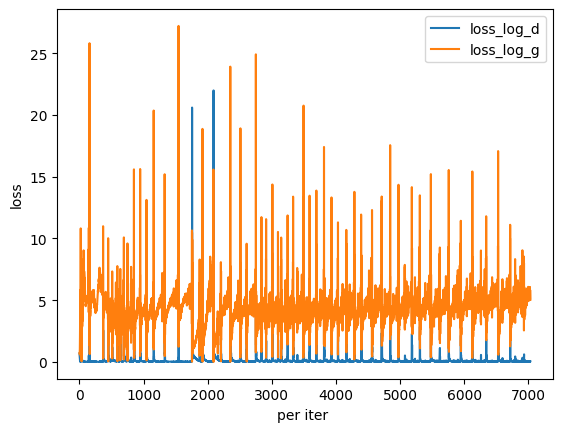

In [ ]:
plt.plot(loss_log['loss_log_d'])
plt.plot(loss_log['loss_log_g'])
plt.xlabel('per iter ')
plt.ylabel('loss')
plt.legend(['loss_log_d', 'loss_log_g'])
""" maybe plot log(loss)

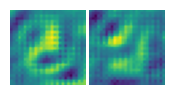

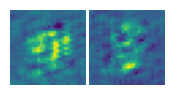

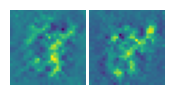

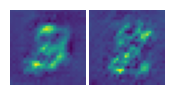

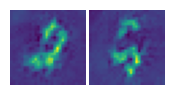

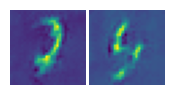

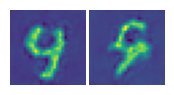

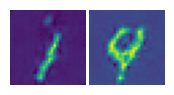

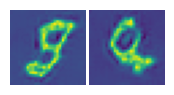

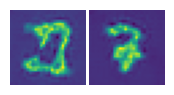

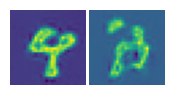

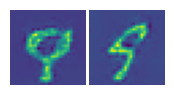

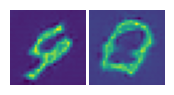

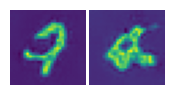

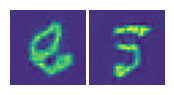

In [ ]:
len(fake_imgs)
type(fake_imgs[0])
for item in fake_imgs:
  show_images(deprocess_img (item [:2]))

### Visualization

torch.Size([128, 1, 28, 28])


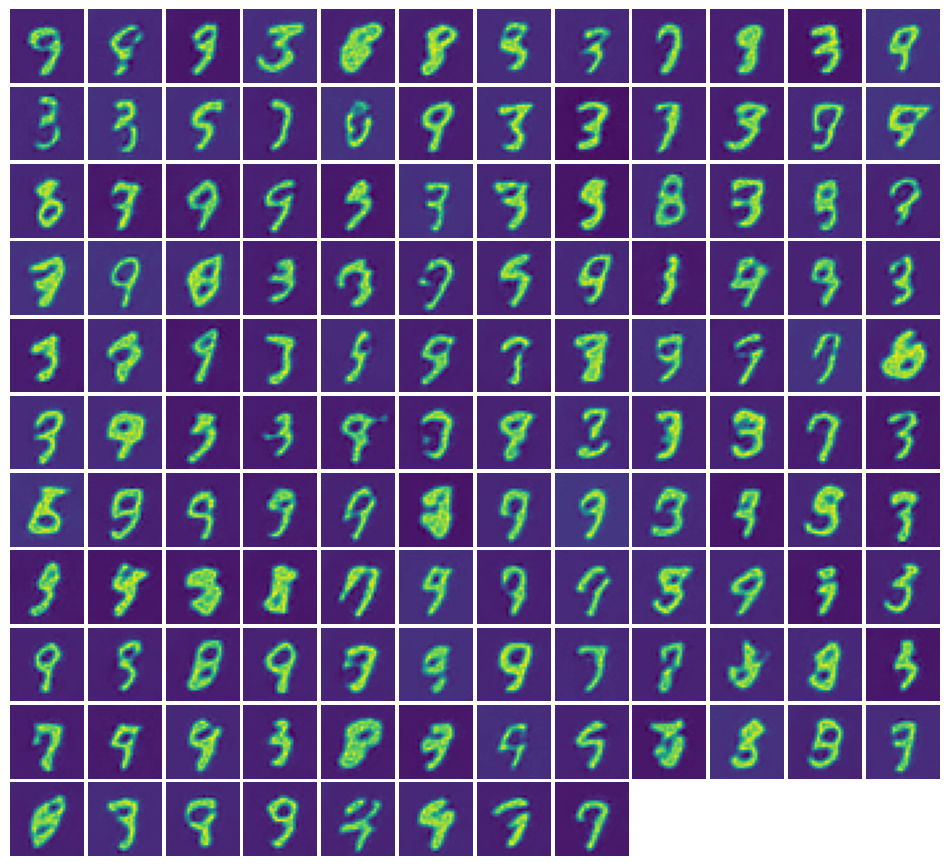

In [ ]:
input_noise = Tensor(generate_noise(batch_size, latent_dim)).to(device)
gen_imgs = dc_generator(input_noise)
print(gen_imgs.shape)
# Visualize generated image
show_images(gen_imgs.detach().cpu())

## Improvements

### Generator

In [ ]:
"""
Transposed convolution instead of upsampling
"""

class Reshape(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(-1,64, 7,7)

class ImprovedGenerator(nn.Module):
    def __init__(self, latent_dim, img_shape, features_g = 16):
        """
        latent_dim: len of noise feature = 100
        img_shape:  num of ouput image channels = 1
        features_g: hyperparameter of hidden_layer_feature_size

        Usage : 
        model = DCGenerator(latent_dim, img_shape ).to(device)
        result = gen3(torch.randn(N,latent_dim,1,1))

        """
        super(ImprovedGenerator, self).__init__()        
        self.img_shape = img_shape

        # Define Generator's layers

        # TODO
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            #
            nn.Linear(latent_dim, 7 * 7 * features_g*4), #latent_dim -> 6272
            Reshape(),
            self._block(features_g*4 ,features_g*2, 4, 2, 0),  #  -> 3x3
            self._block(features_g * 2, features_g * 1, 4, 2, 0),  # -> 7x7
            # self._block(features_g * 16, features_g * 8, 4, 2, 1),  # -> 14x14
            # self._block(features_g * 8, features_g * 4, 3, 1, 1),  # -> 28X28
  
            nn.Conv2d(features_g, 1, kernel_size=7),
            #Output: N x channels_img x 64 x 64
            #nn.Tanh(),
        )
            # END
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding=0,
                bias=True,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(),)
        
    def forward(self, x):
        """
        x: input data
        output: output of the generator
        """
        # Implement forward step of the model
        # TODO
        output = self.net(x)
        # END
        return output

gen4 = ImprovedGenerator(100, 1 ).to(device)
fixed_noise = generate_noise(4,100).to(device)
result = gen4(fixed_noise)
result.shape

### Discriminator

**Spectral normalization**

Please check for the details: 
- https://paperswithcode.com/method/spectral-normalization
- https://arxiv.org/abs/1802.05957

**Least square discriminator**
- https://paperswithcode.com/method/lsgan

**Apply leaky relu activation function in Discriminator**

<center><figure><img src="https://i.imgur.com/y9jXuP4.jpg" width="600"/><figcaption>Graph of the ReLU (left) and LReLU (right) activation functions. <a href="https://qph.cf2.quoracdn.net/main-qimg-68345231be6cb497732a056a51868d98-lq">Image is taken from</a></figcaption></figure></center>

In [ ]:
class SpectralNormalization(nn.Module):
    def __init__(self):
        super(SpectralNormalization, self).__init__()

    def forward(self, x):
        norm_output = None
        # TODO
        # Implement spectral normalization

        # END TODO
        return norm_output


class ImprovedDiscriminator(nn.Module):
    def __init__(self, img_shape,features_d=64):
        super(ImprovedDiscriminator, self).__init__()
        
        # Define Discriminator's layers
        self.disc = nn.Sequential(
            # input: N x channels_img x 28 x 28
            nn.Conv2d(img_shape, features_d, kernel_size=4, stride=2, padding=1),   #28 -> 14
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d*2, 4, 2, 1),  # 14 -> 7
            self._block(features_d * 2, features_d*4, 4, 2, 1), #7 -> 3
            self._block(features_d * 4, features_d*8, 4, 2, 1),# 3 -> 1
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=1, stride=1, padding=0),# 1 ->1
            nn.Sigmoid()
        )

    def _block( self,in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25)
        )
 
    def forward(self, x):
        """
        x: input data
        output: output of the discriminator
        """

        # Implement forward step of the model
        # TODO
        return self.disc(x).squeeze(-1).squeeze(-1)
        # END



result = torch.randn(16,1,28,28)    


de3 = ImprovedDiscriminator(1,features_d=32).to(device)
result.shape

de3(result).shape



In [ ]:
class Reference_Discriminator(nn.Module):
    def __init__(self):
        super(Reference_Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(1, 16, bn=False),   #14x14
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        # ds_size = opt.img_size // 2 ** 4
        self.adv_layer = nn.Linear(512, 1)

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

de5 = Reference_Discriminator().to(device)
print(result.shape)

de5(result).shape

#### Improved Loss Functions

You need to implement Mean Squared Error (MSE), improved generator loss and improved discriminator loss. The idea is based on the improvement that you do in the discriminator. Since our discriminator generates 2D output without linear layer, we need to adapt our GAN loss based on this concept.

In [ ]:
class MSE_loss(nn.Module):
    def __init__(self):
        super(MSE_loss, self).__init__()

    def forward(self, pred, target):
        loss = None
        """
        Implement mean squared error (MSE) loss
        pred: predictions
        target: ground truth
        """
        # TODO
        loss = torch.pow(pred - target,2).mean()
        # END
        return loss
'''
Test
'''
pred = torch.tensor([2,1,1],dtype=torch.float32)  
target = torch.tensor([3.4,0,0]).type_as(pred)      
print(torch.pow(pred - target,2).mean())
f = torch.nn.MSELoss()
f(pred,target)

class improved_generator_loss(nn.Module):
    def __init__(self):
        super(improved_generator_loss, self).__init__()
        self.mse_loss = MSE_loss()
        self.valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)

    def forward(self, scores):
        """
        Implement generator loss by using self.mse_loss
        Input:
            scores: Output scores for the generated data
        Output:
            loss: Calculated loss value for the generator. It must be a scalar.
        """
        loss = None
        # TODO
        loss = self.mse_loss(scores)
        # END
        return loss

class improved_discriminator_loss(nn.Module):
    def __init__(improved_discriminator_loss,self):
        super(improved_discriminator_loss, self).__init__()
        self.mse_loss = MSE_loss()

    def forward(self, scores_real, scores_fake):
        """
        Implement discriminator loss by using self.mse_loss
        Input:
            scores_real: Output scores for the real data
            scores_fake: Output scores for the generated data
        Output:
            loss: Calculated loss value for the discriminator. It must be a scalar.
        """
        loss = None
        # TODO

        # END
        return loss

tensor(1.3200)


### Create model

In [ ]:
latent_dim = 100 # you can change this

# Define generator and discriminator
# TODO
improved_generator = None
improved_generator = ImprovedGenerator(100, 1 ).to(device)
# END

# Perform weight initialization
# TODO
improved_discriminator = None
# improved_discriminator = ImprovedDiscriminator(1,features_d=32).to(device)
improved_discriminator = Reference_Discriminator().to(device)
# END

# Get optimizer
optimizer_imp_G = get_optimizer(improved_generator,lr=2e-4)
optimizer_imp_D = get_optimizer(improved_discriminator,lr=2e-4)
print(optimizer_imp_G)
print(optimizer_imp_D)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)


In [ ]:
from torch.autograd import Variable
adversarial_loss = torch.nn.MSELoss()
num_epochs = 15

fake_imgs = []
loss_log = {'loss_log_d':[],'loss_log_g':[]}

for epoch in range(num_epochs):
    for batch_idx, (imgs, _) in enumerate(data_loader_train):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False).to(device)
        #print(valid.shape)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False).to(device)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor)).to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_imp_G.zero_grad()

        # Sample noise as generator input
        # z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)))).to(device)
        z = Variable(Tensor(torch.randn(imgs.shape[0], latent_dim))).to(device)

        # Generate a batch of images
        gen_imgs = improved_generator(z)

        # Loss measures generator's ability to fool the discriminator
        bv = improved_discriminator(gen_imgs)
        
        g_loss = adversarial_loss(bv, valid)

        g_loss.backward()
        optimizer_imp_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_imp_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(improved_discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(improved_discriminator(gen_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_imp_D.step()

         # Updates loss log
        loss_log['loss_log_d'].append(d_loss.item())
        loss_log['loss_log_g'].append(g_loss.item())


        # Print losses occasionally 
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}] Batch {batch_idx}/{len(data_loader_train)} \
                  Loss D: {d_loss:.4f}, loss G: {g_loss:.4f}"
            )
            
    improved_generator.eval()
    with torch.no_grad():
        # noise = Variable(Tensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)
        noise = Variable(Tensor(torch.randn(batch_size, latent_dim))).to(device)
        fake = improved_generator(noise)
        fake_imgs.append(fake.cpu().detach())
    improved_generator.train()       

Epoch [1/15] Batch 0/469                   Loss D: 0.4774, loss G: 0.9609
Epoch [1/15] Batch 100/469                   Loss D: 0.0493, loss G: 0.6222
Epoch [1/15] Batch 200/469                   Loss D: 0.0730, loss G: 0.6786
Epoch [1/15] Batch 300/469                   Loss D: 0.0957, loss G: 0.3854
Epoch [1/15] Batch 400/469                   Loss D: 0.0737, loss G: 0.6936
Epoch [2/15] Batch 0/469                   Loss D: 0.0770, loss G: 0.6444
Epoch [2/15] Batch 100/469                   Loss D: 0.1113, loss G: 0.5599
Epoch [2/15] Batch 200/469                   Loss D: 0.1136, loss G: 0.3121
Epoch [2/15] Batch 300/469                   Loss D: 0.0919, loss G: 0.5688
Epoch [2/15] Batch 400/469                   Loss D: 0.1415, loss G: 0.5042
Epoch [3/15] Batch 0/469                   Loss D: 0.0904, loss G: 0.6701
Epoch [3/15] Batch 100/469                   Loss D: 0.0982, loss G: 0.4812
Epoch [3/15] Batch 200/469                   Loss D: 0.0900, loss G: 1.0032
Epoch [3/15] Batch

### Training

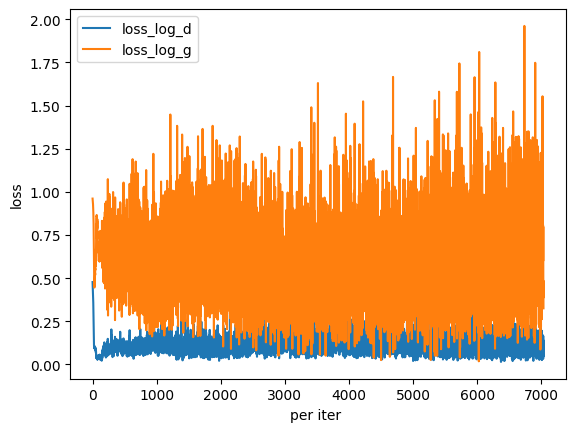

In [ ]:
plt.plot(loss_log['loss_log_d'])
plt.plot(loss_log['loss_log_g'])
plt.xlabel('per iter ')
plt.ylabel('loss')
plt.legend(['loss_log_d', 'loss_log_g'])

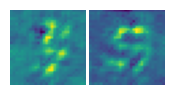

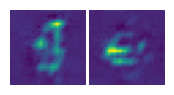

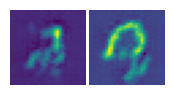

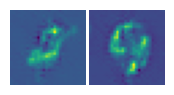

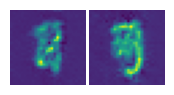

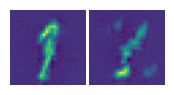

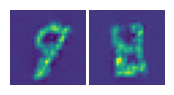

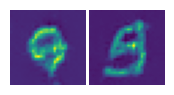

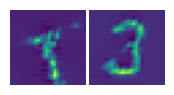

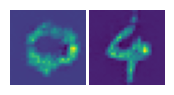

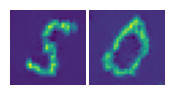

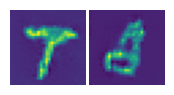

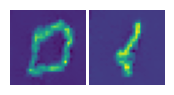

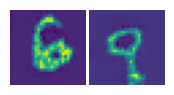

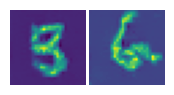

In [ ]:
len(fake_imgs)
type(fake_imgs[0])
for item in fake_imgs:
  show_images(deprocess_img (item [:2]))

### Visualization

torch.Size([128, 1, 28, 28])


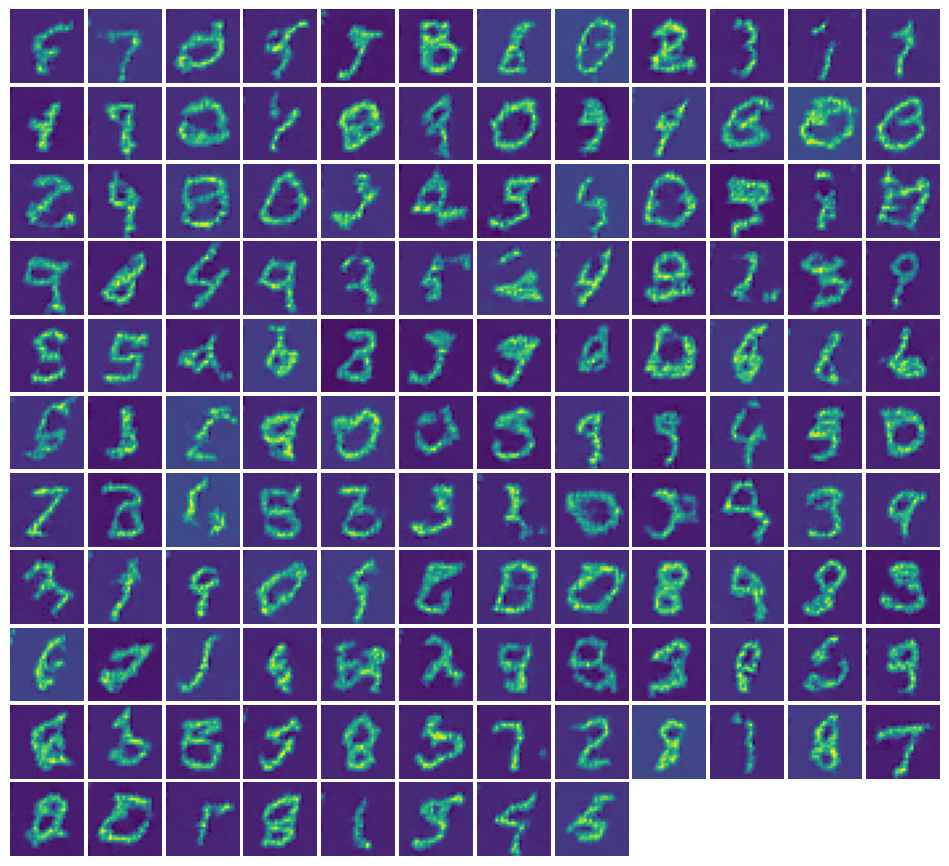

In [ ]:
# input_noise = Tensor(generate_noise(batch_size, latent_dim))
# input_noise = Variable(Tensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

input_noise = Variable(Tensor(torch.randn(batch_size, latent_dim))).to(device)
gen_imgs = improved_generator(input_noise)
print(gen_imgs.shape)
# Visualize generated image
show_images(gen_imgs.cpu().detach())

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=faa4af3b-d086-4f42-8b7d-d29c91b1d0f6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>